In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.3 MB/s eta 0:00:00


### Importing libraries and shapefile

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.features import rasterize
import numpy as np
import rasterio
from rasterio.transform import Affine
from PIL import Image
from skimage import feature
from matplotlib.colors import LinearSegmentedColormap
from affine import Affine
from matplotlib.colors import LogNorm
from sklearn.metrics import pairwise_distances_argmin
from skimage.feature import canny
from skimage.transform import AffineTransform

In [4]:
shapefile_path = "/content/drive/MyDrive/AP/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
shp = gpd.read_file(shapefile_path)
shp = shp.to_crs(epsg=4326)
shp_contig = shp.cx[-125:-66, 24:50]

In [ ]:
shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')

In [ ]:
width, height = 2048, 1024
bounds = shp_contig.total_bounds
transform = [(bounds[2] - bounds[0]) / width, 0, bounds[0], 0, -(bounds[3] - bounds[1]) / height, bounds[3]]
transform_affine = Affine(*transform)

In [ ]:
def rasterize_boundaries(geoms, out_shape, transform):
    return rasterize([(geom, 1) for geom in geoms], out_shape=out_shape, transform=transform, fill=0, dtype=np.uint8)

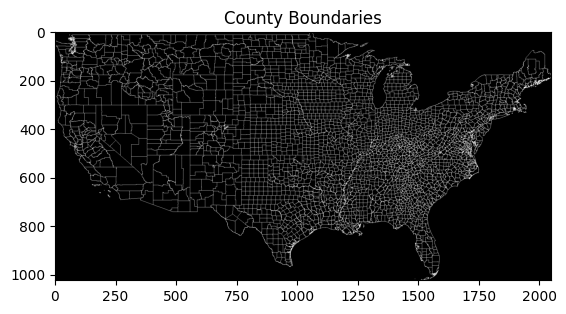

In [ ]:
boundary_mask = rasterize_boundaries(shp_contig.boundary, (height, width), transform_affine)
plt.imshow(boundary_mask, cmap='gray')
plt.title("County Boundaries")
plt.show()

In [ ]:
def generate_smooth_rgb_cmap():
    colors = [
        [0, 0, 0],    # Black
        [1, 0, 0],    # Red
        [1, 1, 0],    # Yellow
        [0, 1, 0],    # Green
        [0, 1, 1],    # Cyan
        [0, 0, 1],    # Blue
        [1, 0, 1],    # Magenta
        [1, 1, 1]     # White
    ]
    return LinearSegmentedColormap.from_list("smooth_rgb", colors, N=128)

def crop_image_to_content(image_path, save_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    mask = np.any(img_np != [255, 255, 255], axis=-1)
    if not np.any(mask):
        print("No non-white content found.")
        return

    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1

    cropped = img.crop((x0, y0, x1, y1))
    if save_path:
        cropped.save(save_path)
    return cropped

def generate_choropleth_from_column(
    gdf,
    column,
    output_path,
    cmap=None,
    n_bins=128,
    projection_epsg=4326,
    xlim=(-125, -66),
    ylim=(24, 50),
    figsize=(19, 10),
    legend=False
):
    cmap = generate_smooth_rgb_cmap()

    gdf = gdf.to_crs(epsg=projection_epsg)
    gdf_crop = gdf.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    gdf_crop.plot(
        column=column,
        cmap=cmap,
        linewidth=0.3,
        edgecolor='0.8',
        ax=ax,
        legend=legend,
        norm=LogNorm(
            vmin=gdf_crop[column].quantile(0.01),
            vmax=gdf_crop[column].quantile(0.99)
        ),
        missing_kwds={"color": "lightgrey"}
    )
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.set_position([0, 0, 1, 1])
    plt.savefig(output_path, dpi=150, bbox_inches=None)
    plt.show()
    plt.close()

    crop_image_to_content(output_path, output_path)
    print(f"Saved and cropped: {output_path}")
    return gdf_crop

### Population Dataset

In [ ]:
path_pop = "/content/drive/MyDrive/AP/cb_2018_us_county_500k/county_pop_data.csv"
df_pop = pd.read_csv(path_pop, dtype={'GEOID': str})

In [ ]:
df_pop.columns

Index(['fips', 'state', 'name', 'pop2000', 'pop2010', 'pop2011', 'pop2012',
       'pop2013', 'pop2014', 'pop2015',
       ...
       'poverty_under_18_2019', 'two_plus_races_2019',
       'unemployment_rate_2019', 'uninsured_2019',
       'uninsured_65_and_older_2019', 'uninsured_under_19_2019',
       'uninsured_under_6_2019', 'veterans_2019', 'white_2019',
       'white_not_hispanic_2019'],
      dtype='object', length=188)

In [ ]:
shp['GEOID'] = shp['GEOID'].astype(int)
merged = shp.merge(df_pop, left_on='GEOID', right_on='fips', how='inner')

In [ ]:
merged.shape

(3142, 198)

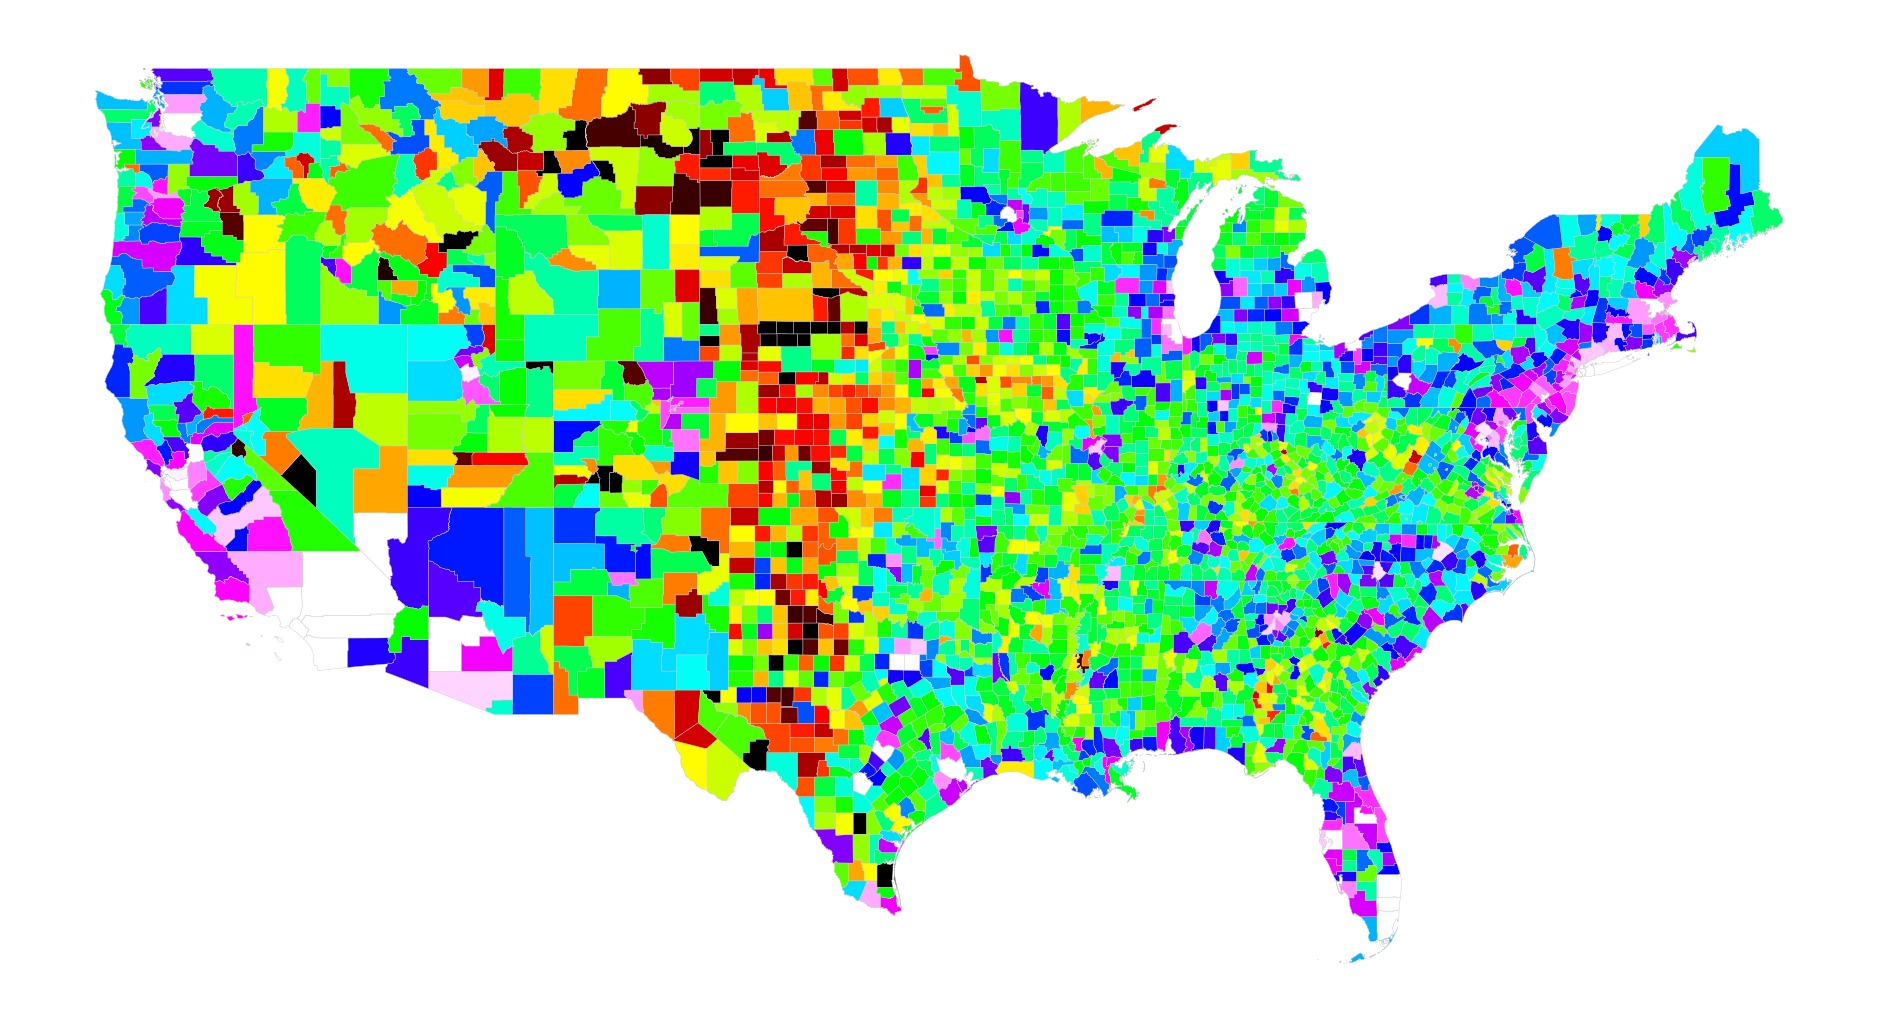

Saved and cropped: /content/drive/MyDrive/AP/map_pop.png


In [ ]:
merged_pop = generate_choropleth_from_column(gdf=merged, column='pop2017', output_path='/content/drive/MyDrive/AP/map_pop.png')

### Align

In [ ]:
img_path = "/content/drive/MyDrive/AP/map_pop.png"
img = Image.open(img_path).convert("L")

In [ ]:
img_resized = img.resize((boundary_mask.shape[1], boundary_mask.shape[0]))
img_np = np.array(img_resized)

In [ ]:
edges_img = feature.canny(img_np, sigma=0.5)

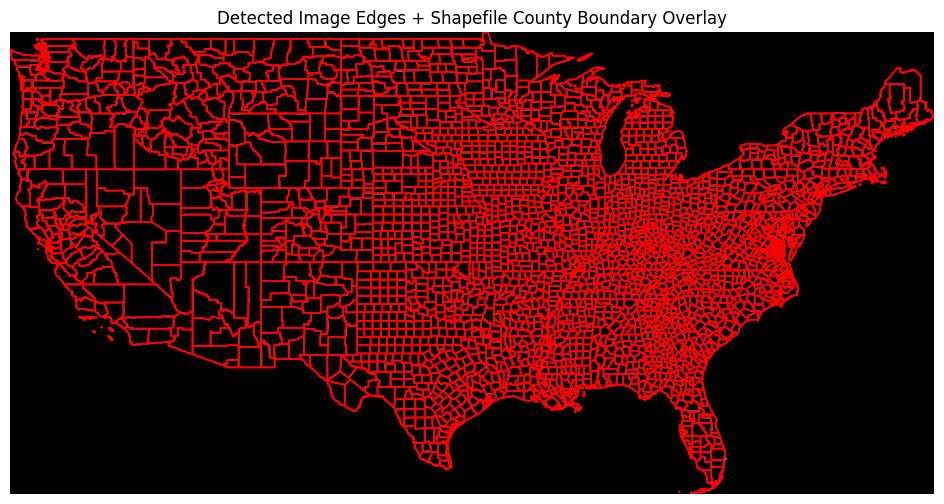

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(edges_img, cmap='gray')
plt.contour(boundary_mask, colors='red', linewidths=0.5)
plt.title("Detected Image Edges + Shapefile County Boundary Overlay")
plt.axis("off")
plt.show()

In [ ]:
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)
height, width = img_np.shape[:2]

In [ ]:
gdf = merged_pop.copy()
gdf['interior'] = gdf.geometry.representative_point()

In [ ]:
bounds = gdf.total_bounds
xres = (bounds[2] - bounds[0]) / width
yres = (bounds[3] - bounds[1]) / height
transform = Affine.translation(bounds[0], bounds[3]) * Affine.scale(xres, -yres)

def pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

pixel_coords = gdf['interior'].apply(lambda pt: pixel(pt.x, pt.y, transform))
pixel_coords = np.array(pixel_coords.to_list())

In [ ]:
def rgb(img_array, pixel_coords):
    h, w = img_array.shape[:2]
    rgb_vals = []
    for y, x in pixel_coords:
        if 0 <= y < h and 0 <= x < w:
            rgb_vals.append(tuple(img_array[y, x]))
        else:
            rgb_vals.append((0, 0, 0))
    return rgb_vals

gdf['rgb'] = rgb(img_np, pixel_coords)

In [ ]:
print(gdf[['GEOID', 'pop2017', 'rgb']])

      GEOID   pop2017              rgb
0     21007    8039.0    (231, 255, 0)
1     21017   20029.0      (6, 255, 0)
2     21031   12831.0    (118, 255, 0)
3     21065   14277.0     (90, 255, 0)
4     21069   14446.0     (90, 255, 0)
...     ...       ...              ...
3137  31073    2028.0      (183, 0, 0)
3138  39075   43957.0    (0, 255, 191)
3139  48171   26646.0     (0, 255, 64)
3140  55079  952085.0  (255, 199, 255)
3141  26139  286383.0    (145, 0, 255)

[3108 rows x 3 columns]


In [ ]:
def rgb_leg(n_bins):
    cmap = generate_smooth_rgb_cmap()
    return (np.array([cmap(i / n_bins)[:3] for i in range(n_bins)]) * 255).astype(int)

rgb_legend = rgb_leg(128)
rgb_array = np.array(gdf['rgb'].tolist())
bin_indices = pairwise_distances_argmin(rgb_array, rgb_legend)
gdf['bin_index'] = bin_indices

In [ ]:
vmin = gdf['pop2017'].quantile(0.01)
vmax = gdf['pop2017'].quantile(0.99)

bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), 129)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

gdf['estimated_pop'] = gdf['bin_index'].apply(lambda i: bin_centers[i])

In [ ]:
gdf['abs_error'] = np.abs(gdf['pop2017'] - gdf['estimated_pop'])
gdf['rel_error'] = gdf['abs_error'] / gdf['pop2017']

mean_abs_error = gdf['abs_error'].mean()
mean_rel_error = gdf['rel_error'].mean()
accuracy_within_5_percent = (gdf['rel_error'] <= 0.05).mean() * 100

print(f"Mean relative error: {mean_rel_error:.2%}")
print(f"Accuracy within 5%: {accuracy_within_5_percent:.2f}%")

Mean relative error: 45.65%
Accuracy within 5%: 96.98%


### Mortality Rates Dataset

In [ ]:
path_mor = "/content/drive/MyDrive/AP/cb_2018_us_county_500k/county_mortality_data_clean.csv"
df_mor = pd.read_csv(path_mor)

In [ ]:
df_mor.columns

Index(['GEOID', 'val'], dtype='object')

In [ ]:
# df_mor['val'] = df_mor['val'].fillna(df_mor['val'].median())

In [ ]:
shp['GEOID'] = shp['GEOID'].astype(int)
merged = shp.merge(df_mor, left_on='GEOID', right_on='GEOID', how='inner')
# merged = merged.dissolve(by='GEOID', aggfunc={'val': 'mean'})

In [ ]:
# merged_clean = merged.reset_index().drop(columns='geometry')
# output_path = "/content/drive/MyDrive/AP/cb_2018_us_county_500k/county_mortality_data_clean.csv"
# merged_clean.to_csv(output_path, index=False)
# print(f"Saved the clean mortality data at: {output_path}")

In [ ]:
merged.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'val'],
      dtype='object')

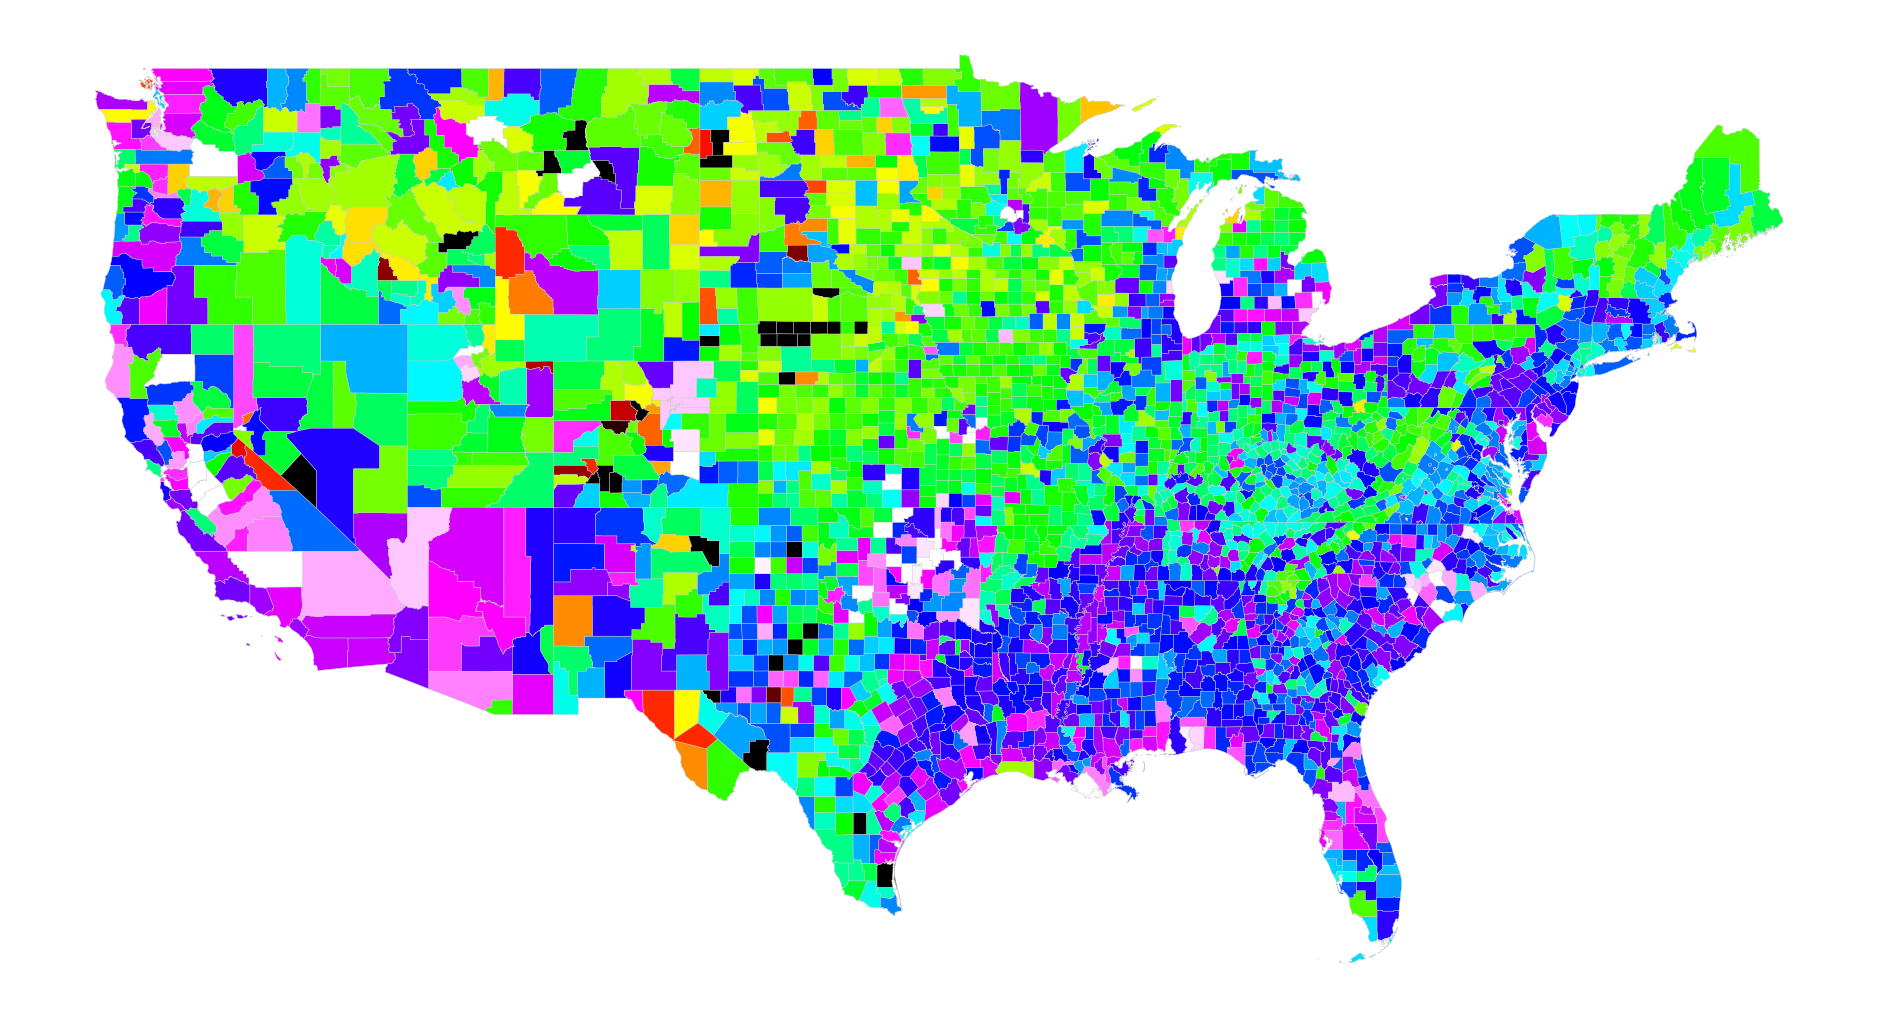

Saved and cropped: /content/drive/MyDrive/AP/map_mor.png


In [ ]:
merged_mor = generate_choropleth_from_column(gdf=merged, column='val', output_path='/content/drive/MyDrive/AP/map_mor.png')

In [ ]:
merged_mor.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'val'],
      dtype='object')

In [ ]:
img_path = "/content/drive/MyDrive/AP/map_mor.png"
img = Image.open(img_path).convert("L")

In [ ]:
img_resized = img.resize((boundary_mask.shape[1], boundary_mask.shape[0]))
img_np = np.array(img_resized)

In [ ]:
edges_img = feature.canny(img_np, sigma=0.5)

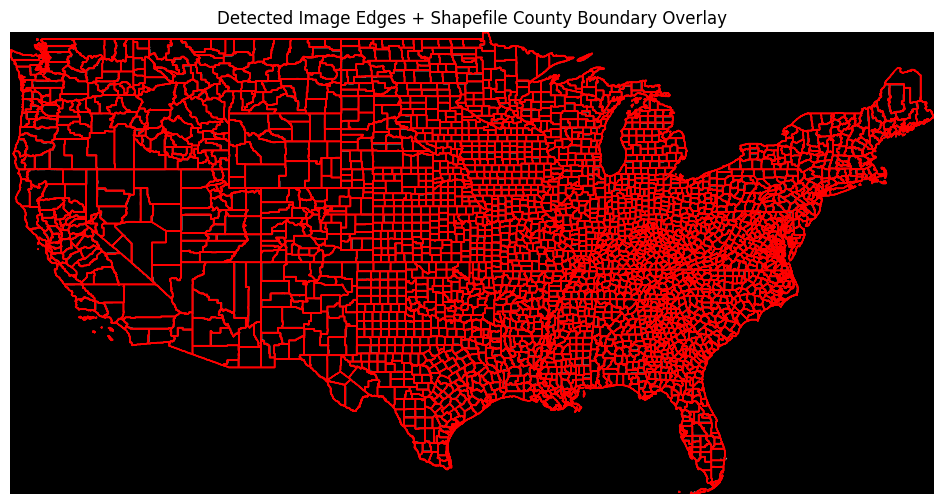

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(edges_img, cmap='gray')
plt.contour(boundary_mask, colors='red', linewidths=0.5)
plt.title("Detected Image Edges + Shapefile County Boundary Overlay")
plt.axis("off")
plt.show()

In [ ]:
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)
height, width = img_np.shape[:2]

In [ ]:
gdf = merged_mor.copy()
gdf['interior'] = gdf.geometry.representative_point()

In [ ]:
bounds = gdf.total_bounds
xres = (bounds[2] - bounds[0]) / width
yres = (bounds[3] - bounds[1]) / height
transform = Affine.translation(bounds[0], bounds[3]) * Affine.scale(xres, -yres)

pixel_coords = gdf['interior'].apply(lambda pt: pixel(pt.x, pt.y, transform))
pixel_coords = np.array(pixel_coords.to_list())

In [ ]:
gdf['rgb'] = rgb(img_np, pixel_coords)

In [ ]:
print(gdf[['GEOID', 'val', 'rgb']])

      GEOID       val              rgb
0     21007  0.009625    (0, 255, 135)
1     21017  0.011742     (0, 66, 255)
2     21031  0.009468    (0, 255, 106)
3     21065  0.010664    (0, 221, 255)
4     21069  0.010296    (0, 255, 233)
...     ...       ...              ...
3103  31073  0.007944    (175, 255, 0)
3104  39075  0.008390     (90, 255, 0)
3105  48171  0.009274     (0, 255, 64)
3106  55079  0.016359  (255, 213, 255)
3107  26139  0.012336     (18, 0, 255)

[3108 rows x 3 columns]


In [ ]:
rgb_legend = rgb_leg(128)
rgb_array = np.array(gdf['rgb'].tolist())
bin_indices = pairwise_distances_argmin(rgb_array, rgb_legend)
gdf['bin_index'] = bin_indices

In [ ]:
vmin = gdf['val'].quantile(0.01)
vmax = gdf['val'].quantile(0.99)

bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), 129)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

gdf['estimated_mor'] = gdf['bin_index'].apply(lambda i: bin_centers[i])

In [ ]:
gdf['abs_error'] = np.abs(gdf['val'] - gdf['estimated_mor'])
gdf['rel_error'] = gdf['abs_error'] / gdf['val']

mean_abs_error = gdf['abs_error'].mean()
mean_rel_error = gdf['rel_error'].mean()
accuracy_within_5_percent = (gdf['rel_error'] <= 0.05).mean() * 100

print(f"Mean relative error: {mean_rel_error:.2%}")
print(f"Accuracy within 5%: {accuracy_within_5_percent:.2f}%")

Mean relative error: 0.81%
Accuracy within 5%: 97.75%


### Test 1

In [ ]:
shapefile_path = "/content/drive/MyDrive/AP/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
shp = gpd.read_file(shapefile_path)
shp5070 = shp.to_crs(epsg=5070)
shp5070 = shp5070[~shp5070["STATEFP"].isin(["02", "15", "72"])]
shp5070['interior'] = shp5070.geometry.representative_point()

In [ ]:
x_min, x_max = -2400000, 2300000
y_min, y_max = 300000, 3200000

In [ ]:
shp5070 = shp5070.cx[x_min:x_max, y_min:y_max]

In [ ]:
width, height = 2048, 1024
bounds = shp5070.total_bounds
transform = [(bounds[2] - bounds[0]) / width, 0, bounds[0], 0, -(bounds[3] - bounds[1]) / height, bounds[3]]
transform_affine = Affine(*transform)

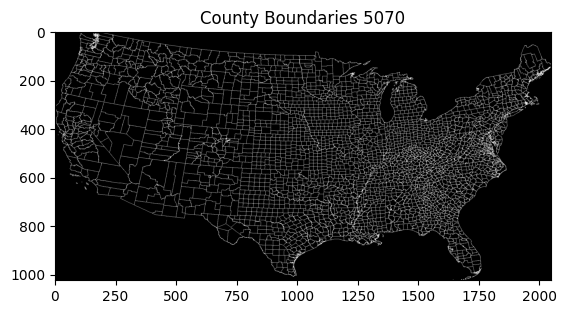

In [ ]:
boundary_mask = rasterize_boundaries(shp5070.boundary, (height, width), transform_affine)
plt.imshow(boundary_mask, cmap='gray')
plt.title("County Boundaries 5070")
plt.show()

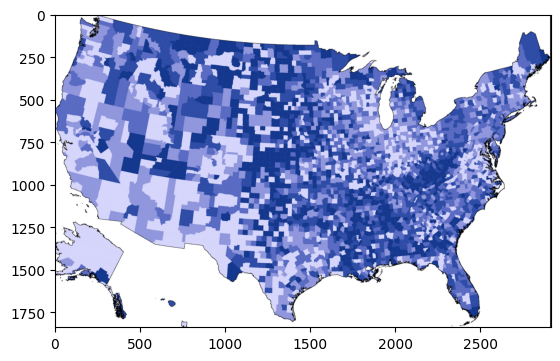

In [ ]:
img_path = "/content/drive/MyDrive/AP/test01.png"
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.show()

In [ ]:
cropped_img = crop_image_to_content(img_path, img_path)

In [ ]:
img = Image.open(img_path).convert("L")

In [ ]:
img_resized = img.resize((boundary_mask.shape[1], boundary_mask.shape[0]))
img_np = np.array(img_resized)

In [ ]:
img_np.shape

(1024, 2048)

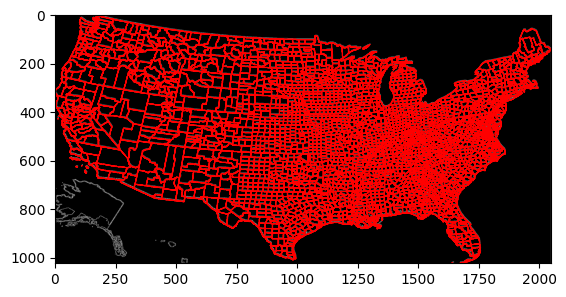

In [ ]:
edges = canny(img_np, sigma=0)
plt.imshow(edges, cmap='gray')
plt.contour(boundary_mask, colors='red', linewidths=0.5)

In [ ]:
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)
img_resized = img.resize((boundary_mask.shape[1], boundary_mask.shape[0]))
img_np = np.array(img_resized)

In [ ]:
height, width = img_np.shape[:2]
height, width

(1024, 2048)

In [ ]:
gdf = shp5070.copy()
gdf['interior'] = gdf.geometry.representative_point()

In [ ]:
bounds = gdf.total_bounds
xres = (bounds[2] - bounds[0]) / width
yres = (bounds[3] - bounds[1]) / height
transform = Affine.translation(bounds[0], bounds[3]) * Affine.scale(xres, -yres)

def pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

pixel_coords = gdf['interior'].apply(lambda pt: pixel(pt.x, pt.y, transform))
pixel_coords = np.array(pixel_coords.to_list())

In [ ]:
def rgb(img_array, pixel_coords):
    h, w = img_array.shape[:2]
    rgb_vals = []
    for y, x in pixel_coords:
        if 0 <= y < h and 0 <= x < w:
            rgb_vals.append(tuple(img_array[y, x]))
        else:
            rgb_vals.append((0, 0, 0))
    return rgb_vals

gdf['rgb'] = rgb(img_np, pixel_coords)

In [ ]:
print(gdf[['GEOID', 'rgb']])

      GEOID              rgb
0     21007    (47, 77, 167)
1     21017    (47, 77, 167)
2     21031   (90, 107, 195)
3     21065    (20, 55, 142)
4     21069   (90, 107, 195)
...     ...              ...
3228  31073  (214, 214, 252)
3229  39075  (214, 214, 252)
3230  48171  (144, 151, 221)
3231  55079  (140, 147, 214)
3232  26139  (214, 214, 252)

[3108 rows x 2 columns]


In [ ]:
unique_rgbs = gdf['rgb'].unique()
count = 0
for rgb in unique_rgbs:
  count += 1

print(count)

365


In [ ]:
gdf[['GEOID', 'NAME', 'rgb']]

KeyError: "['GEOID', 'NAME'] not in index"

In [ ]:
img_path = "/content/drive/MyDrive/AP/test1legend.png"
img = Image.open(img_path).convert("RGB")

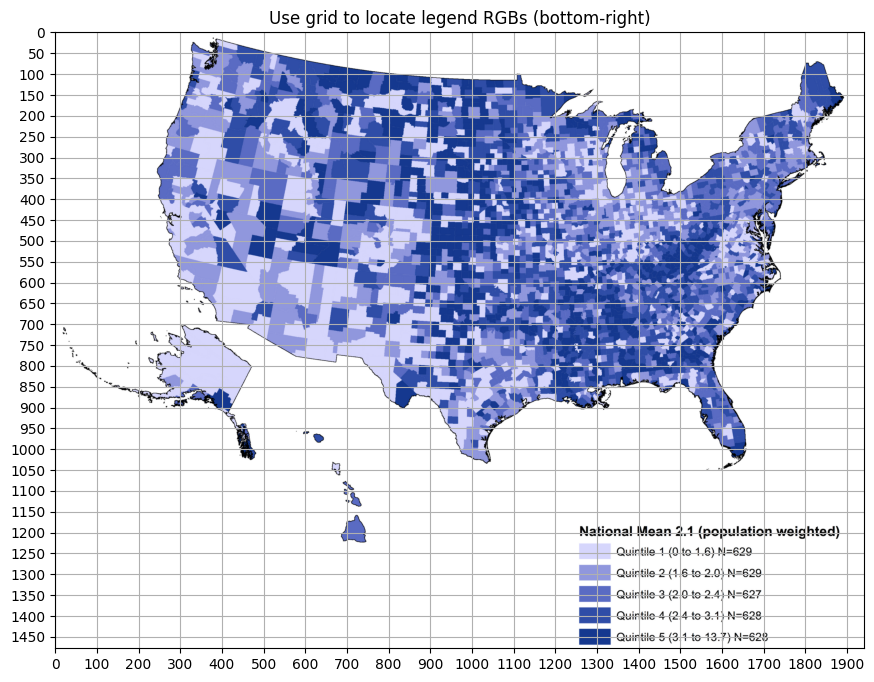

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.title("Use grid to locate legend RGBs (bottom-right)")
plt.xticks(np.arange(0, img.width, 100))
plt.yticks(np.arange(0, img.height, 50))
plt.grid(True)
plt.show()

In [ ]:
x, y = 1300, 1450
rgb_val = img.getpixel((x, y))
rgb_val

(21, 56, 143)

**Noting down the RGB values of the legend manually:**
1. Quintile 1: (214, 214, 252)
2. Quintile 2: (144, 151, 221)
3. Quintile 3: (90, 107, 195)
4. Quintile 4: (47, 77, 167)
5. Quintile 5: (21, 56, 143)

In [ ]:
legend_rgb_to_quintile = {
    (214, 214, 252): "1",
    (144, 151, 221): "2",
    (90, 107, 195):  "3",
    (47, 77, 167):   "4",
    (21, 56, 143):   "5"
}

In [ ]:
legend_rgbs = np.array(list(legend_rgb_to_quintile.keys()))
legend_labels = list(legend_rgb_to_quintile.values())
county_rgbs = np.array(gdf['rgb'].tolist())
nearest_indices = pairwise_distances_argmin(county_rgbs, legend_rgbs)
gdf['quintile no.'] = [legend_labels[i] for i in nearest_indices]

In [ ]:
unique_quin = gdf['quintile no.'].unique()
count = 0
for quin in unique_quin:
  count += 1

print(count)

5


In [ ]:
gdf['rgb'] = gdf['rgb'].apply(lambda x: tuple(int(v) for v in x))

In [ ]:
gdf.columns

Index(['State FIPS', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'County FIPS',
       'County Name', 'LSAD', 'ALAND', 'AWATER', 'geometry', 'interior', 'rgb',
       'quintile', 'quintile no.', 'State Name'],
      dtype='object')

In [ ]:
gdf = gdf.rename(columns={'FIPS': 'County FIPS', 'NAME': 'County Name', 'STATEFP': 'State FIPS'})
gdf = gdf.rename(columns={'quintile no.': 'quintile no'})

In [ ]:
gdf_sorted = gdf_sorted.rename(columns={'quintile no': 'Quintile No', 'quintile': 'Quintile'})

In [ ]:
fips_to_state = {
    "01": "Alabama", "02": "Alaska", "04": "Arizona", "05": "Arkansas", "06": "California", "08": "Colorado", "09": "Connecticut", "10": "Delaware",
    "11": "District of Columbia", "12": "Florida", "13": "Georgia", "15": "Hawaii", "16": "Idaho", "17": "Illinois", "18": "Indiana", "19": "Iowa",
    "20": "Kansas", "21": "Kentucky", "22": "Louisiana", "23": "Maine", "24": "Maryland", "25": "Massachusetts", "26": "Michigan", "27": "Minnesota",
    "28": "Mississippi", "29": "Missouri", "30": "Montana", "31": "Nebraska", "32": "Nevada", "33": "New Hampshire", "34": "New Jersey", "35": "New Mexico",
    "36": "New York", "37": "North Carolina", "38": "North Dakota", "39": "Ohio", "40": "Oklahoma", "41": "Oregon", "42": "Pennsylvania", "44": "Rhode Island",
    "45": "South Carolina", "46": "South Dakota", "47": "Tennessee", "48": "Texas", "49": "Utah", "50": "Vermont", "51": "Virginia", "53": "Washington",
    "54": "West Virginia", "55": "Wisconsin", "56": "Wyoming", "72": "Puerto Rico"
}

In [ ]:
gdf['State FIPS'] = gdf['State FIPS'].astype(str)
gdf['State Name'] = gdf['State FIPS'].map(fips_to_state)

In [ ]:
gdf[['County FIPS', 'State FIPS', 'State Name', 'County Name', 'quintile', 'quintile no.']]

,County FIPS,State FIPS,State Name,County Name,quintile,quintile no.
0,21007,21,Kentucky,Ballard,Quintile 4 (2.4 to 3.1),4
1,21017,21,Kentucky,Bourbon,Quintile 4 (2.4 to 3.1),4
2,21031,21,Kentucky,Butler,Quintile 3 (2.0 to 2.4),3
3,21065,21,Kentucky,Estill,Quintile 5 (3.1 to 13.7),5
4,21069,21,Kentucky,Fleming,Quintile 3 (2.0 to 2.4),3
...,...,...,...,...,...,...
3228,31073,31,Nebraska,Gosper,Quintile 1 (0 to 1.6),1
3229,39075,39,Ohio,Holmes,Quintile 1 (0 to 1.6),1
3230,48171,48,Texas,Gillespie,Quintile 2 (1.6 to 2.0),2
3231,55079,55,Wisconsin,Milwaukee,Quintile 2 (1.6 to 2.0),2


In [ ]:
gdf_sorted = gdf.sort_values(by='State Name')
gdf_sorted[['State FIPS', 'State Name', 'County FIPS', 'County Name', 'quintile no', 'quintile']]

,State FIPS,State Name,County FIPS,County Name,quintile no,quintile
479,01,Alabama,01119,Sumter,4,Quintile 4 (2.4 to 3.1)
1190,01,Alabama,01021,Chilton,3,Quintile 3 (2.0 to 2.4)
1021,01,Alabama,01047,Dallas,5,Quintile 5 (3.1 to 13.7)
1183,01,Alabama,01071,Jackson,3,Quintile 3 (2.0 to 2.4)
3030,01,Alabama,01079,Lawrence,4,Quintile 4 (2.4 to 3.1)
...,...,...,...,...,...,...
840,56,Wyoming,56003,Big Horn,4,Quintile 4 (2.4 to 3.1)
841,56,Wyoming,56013,Fremont,4,Quintile 4 (2.4 to 3.1)
2419,56,Wyoming,56011,Crook,4,Quintile 4 (2.4 to 3.1)
1577,56,Wyoming,56001,Albany,2,Quintile 2 (1.6 to 2.0)


In [ ]:
gdf_sorted['State FIPS'] = gdf_sorted['State FIPS'].astype(str).str.zfill(2)
gdf_sorted['County FIPS'] = gdf_sorted['County FIPS'].astype(str).str.zfill(5)

In [ ]:
gdf_sorted[['State FIPS', 'State Name', 'County FIPS', 'County Name', 'Quintile No', 'Quintile']]

,State FIPS,State Name,County FIPS,County Name,Quintile No,Quintile
479,01,Alabama,01119,Sumter,4,Quintile 4 (2.4 to 3.1)
1190,01,Alabama,01021,Chilton,3,Quintile 3 (2.0 to 2.4)
1021,01,Alabama,01047,Dallas,5,Quintile 5 (3.1 to 13.7)
1183,01,Alabama,01071,Jackson,3,Quintile 3 (2.0 to 2.4)
3030,01,Alabama,01079,Lawrence,4,Quintile 4 (2.4 to 3.1)
...,...,...,...,...,...,...
840,56,Wyoming,56003,Big Horn,4,Quintile 4 (2.4 to 3.1)
841,56,Wyoming,56013,Fremont,4,Quintile 4 (2.4 to 3.1)
2419,56,Wyoming,56011,Crook,4,Quintile 4 (2.4 to 3.1)
1577,56,Wyoming,56001,Albany,2,Quintile 2 (1.6 to 2.0)


In [ ]:
gdf_sorted[['State FIPS', 'State Name', 'County FIPS', 'County Name', 'Quintile No', 'Quintile']].to_csv("/content/drive/MyDrive/AP/extracted_data.csv", index=False)